In [202]:
!pip install emoji
!pip install fasttext
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install flask
!pip install scikit-learn

In [203]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify
import io

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [204]:
vocab_size = 2957
embedding_dim = 300
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 900
num_epochs = 20

In [205]:
sentences = []
labels = []

# Load the dataset
url = "https://raw.githubusercontent.com/RusiruWijethilake/DepFlow/main/updated_dataset.csv"
df = pd.read_csv(url)

df = df.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe
for x in range(len(df)):
    sentences.append(df.iloc[x][0])
    labels.append(df.iloc[x][1])

In [206]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [207]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print(len(word_index))

print(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

3981
{'<OOV>': 1, 'මට': 2, 'මම': 3, 'නෑ': 4, 'වෙලා': 5, 'කරන්න': 6, 'මේ': 7, 'එපා': 8, 'කියලා': 9, 'ඒ': 10, 'ගොඩක්': 11, 'මන්': 12, 'මගේ': 13, 'එක': 14, 'දැන්': 15, 'නිසා': 16, 'කෙනෙක්': 17, 'මං': 18, 'වගේ': 19, 'ගන්න': 20, 'ඉන්න': 21, 'ගැන': 22, 'හිතෙනවා': 23, 'හරි': 24, 'වෙන්න': 25, 'ඉන්නේ': 26, 'නම්': 27, 'ලොකු': 28, 'එක්ක': 29, 'ඒත්': 30, 'දේවල්': 31, 'ඒක': 32, 'දෙයක්': 33, 'හිත': 34, 'නැති': 35, 'යන්න': 36, 'ආදරේ': 37, 'ජීවිතේ': 38, 'නැ': 39, 'වෙනවා': 40, 'එකක්': 41, 'කරන': 42, 'කතා': 43, 'කියන්න': 44, 'ඔබ': 45, 'එයා': 46, 'ඇති': 47, 'දුක': 48, 'තියෙන්නේ': 49, 'වේදනාව': 50, 'බැරි': 51, 'ඕන': 52, 'බෑ': 53, 'කිසිම': 54, 'හැම': 55, 'මානසික': 56, 'උනා': 57, 'පුලුවන්': 58, 'වෙන': 59, 'නැහැ': 60, 'මාව': 61, 'කියල': 62, 'එහෙම': 63, 'කරලා': 64, 'තියෙනවා': 65, 'මේක': 66, 'කියන': 67, 'දෙන්න': 68, 'අපි': 69, 'උදව්': 70, 'ගෙදර': 71, 'පාඩම්': 72, 'මිනිස්සු': 73, 'ඉන්නෙ': 74, 'ඇයි': 75, 'වඩා': 76, 'වලට': 77, 'වෙයි': 78, 'කරනවා': 79, 'වෙනස්': 80, 'නිතරම': 81, 'යනවා': 82, 'අනේ': 83, 'දේ': 84, 'ගො

In [208]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [209]:
import fasttext.util

# Load FastText model
ft = fasttext.load_model("cc.si.300.bin")

# Get embedding dimensions
embedding_dim = ft.get_dimension()

# Mapping FastText word vectors with word in the dataset
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [210]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128, dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 300)           1194600   
                                                                 
 lstm_12 (LSTM)              (None, 128)               219648    
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,414,377
Trainable params: 219,777
Non-trainable params: 1,194,600
_________________________________________________________________


In [211]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=32, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[checkpoint])

Epoch 1/20
29/29 - 2s - loss: 0.6474 - accuracy: 0.6489 - val_loss: 0.6041 - val_accuracy: 0.6699 - 2s/epoch - 86ms/step
Epoch 2/20
29/29 - 0s - loss: 0.5607 - accuracy: 0.6889 - val_loss: 0.5393 - val_accuracy: 0.7282 - 474ms/epoch - 16ms/step
Epoch 3/20
29/29 - 0s - loss: 0.5039 - accuracy: 0.7533 - val_loss: 0.5521 - val_accuracy: 0.7573 - 463ms/epoch - 16ms/step
Epoch 4/20
29/29 - 0s - loss: 0.4712 - accuracy: 0.7644 - val_loss: 0.5491 - val_accuracy: 0.7379 - 419ms/epoch - 14ms/step
Epoch 5/20
29/29 - 0s - loss: 0.4544 - accuracy: 0.7900 - val_loss: 0.5215 - val_accuracy: 0.7524 - 427ms/epoch - 15ms/step
Epoch 6/20
29/29 - 0s - loss: 0.4236 - accuracy: 0.8189 - val_loss: 0.6215 - val_accuracy: 0.7233 - 433ms/epoch - 15ms/step
Epoch 7/20
29/29 - 0s - loss: 0.4582 - accuracy: 0.7911 - val_loss: 0.5406 - val_accuracy: 0.7427 - 412ms/epoch - 14ms/step
Epoch 8/20
29/29 - 0s - loss: 0.4003 - accuracy: 0.8267 - val_loss: 0.6155 - val_accuracy: 0.7330 - 401ms/epoch - 14ms/step
Epoch 9/20


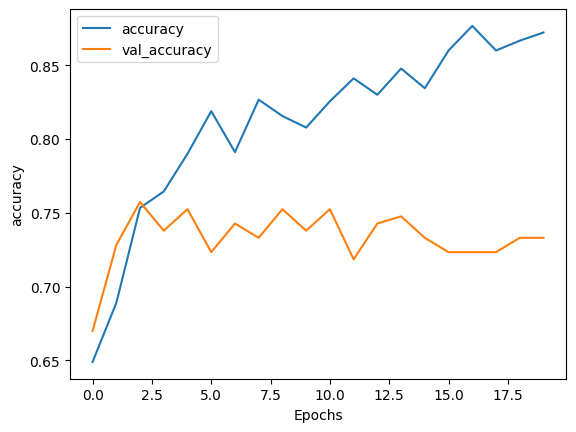

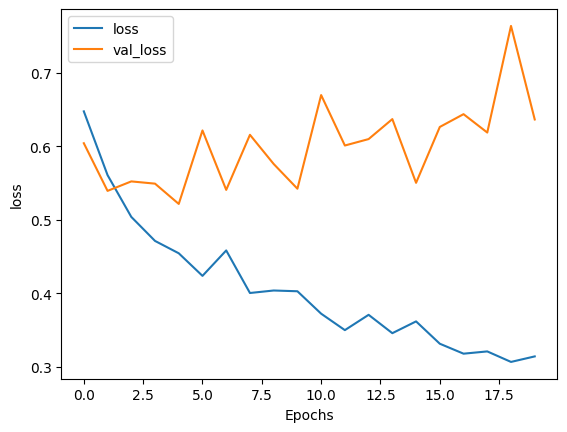

In [212]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [213]:
# Model Evaluation
eval_sequences = tokenizer.texts_to_sequences(testing_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(eval_padded)
predicted_labels = []
for x in pred:
  predicted_labels.append(int(x.round().item()))

predicted_labels = tf.convert_to_tensor(predicted_labels)
print(classification_report(testing_labels, predicted_labels))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       117
           1       0.65      0.81      0.72        89

    accuracy                           0.73       206
   macro avg       0.74      0.74      0.73       206
weighted avg       0.75      0.73      0.73       206



In [214]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

මම ගොඩාක් ලැජ්ජාශීලී කෙනෙක් උනා මිනිස්සු එක්ක වචනයක් වත් කතා කරන්නේ නැති එකෙනෙක් උනා ? ? ? ? ? ?
රැදි සිටින්නමි තුරැලු වෙලා
0


In [215]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(3982, 300)


In [216]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [217]:
!mkdir -p saved_model
model.save('depflow_trained_model.h5')

In [218]:
sentence = ["මට ඇති මේ දුක දරන් හිටියා.", "මට සතුටුයි හොදටම"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 28ms/step
[[0.92764485]
 [0.4639599 ]]


In [219]:
def check_depressive(post: str):
  sentence = [post]
  sequences = tokenizer.texts_to_sequences(sentence)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  post_prediction = model.predict(padded)
  label = post_prediction.round().item()
  if label >= 1 :
    print(post, " : is a depressive post - ", post_prediction)
  else:
    print(post, " : is not a depressive post - ", post_prediction)
  return label >= 1

check_depressive("මට ඇති මේ දුක දරන් හිටියා.")
check_depressive("මම මැරිලා ම යන්නම්")
check_depressive("මම මරිලා ගියාම හැමොටම හොදයි.")
check_depressive("දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි")
check_depressive("අපි හෙට උදේට මොනවද කන්නේ?")
check_depressive('ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ')
check_depressive('ඔයාටනම් ඉතින් හිනා')
check_depressive('මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී')
check_depressive('මට හොදටම depression')
check_depressive('I feel like I want to cry')
check_depressive('මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා')

1/1 [==============================] - 0s 23ms/step
මට ඇති මේ දුක දරන් හිටියා.  : is a depressive post -  [[0.92764485]]
1/1 [==============================] - 0s 21ms/step
මම මැරිලා ම යන්නම්  : is a depressive post -  [[0.80653155]]
1/1 [==============================] - 0s 15ms/step
මම මරිලා ගියාම හැමොටම හොදයි.  : is not a depressive post -  [[0.45952427]]
1/1 [==============================] - 0s 21ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි  : is a depressive post -  [[0.69695413]]
1/1 [==============================] - 0s 18ms/step
අපි හෙට උදේට මොනවද කන්නේ?  : is not a depressive post -  [[0.0021362]]
1/1 [==============================] - 0s 25ms/step
ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ  : is a depressive post -  [[0.96090555]]
1/1 [==============================] - 0s 16ms/step
ඔයාටනම් ඉතින් හිනා  : is not a depressive post -  [[0.20739579]]
1/1 [==============================] - 0s 16ms/step
මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී  : is a depressive post -  [[0.9458526]]
1/1 [===========

True

In [220]:
app = Flask(__name__)

@app.route("/")
def hello_world():
    return "<p>Hello, World!</p>"

@app.route("/predict", methods=['POST'])
def predict():
    data = request.json
    userid = data['user']['userid']
    posts = data['posts']

    if len(posts) == 0:
        return jsonify([])
    else:
        if userid != '':
            post_ids = [id['post_id'] for id in posts]
            sentences = [post['post_value'] for post in posts]

            result_set = []

            for i in range(len(sentences)):
                label = check_depressive(sentences[i])

                if label == True:
                    result_set.append({
                        'post_id': post_ids[i],
                        'label': 'depressive'
                    })
                else:
                    result_set.append({
                        'post_id': post_ids[i],
                        'label': 'natural'
                    })

            return jsonify(result_set)
        else:
            return jsonify([])

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


1/1 [==============================] - 0s 39ms/step
Elon musk is working on “EQUALITY” 
 We all are same on Twitter at least .. 
what’s wrong with that :relieved::relieved::relieved:  : is not a depressive post -  [[0.01897246]]
1/1 [==============================] - 0s 30ms/step
අර සංගීතේ කියන කතාවෙ යන්නේ අනික් උන්ට අංචි අදින එක ගැනනේ ................. :face_palm::face_palm::face_palm::face_palm: මොනාද දෙවියනේ මේ කතා  : is not a depressive post -  [[0.0034148]]
1/1 [==============================] - 0s 27ms/step
#TweepsIftar is the annual Ramadan community event organized by the tweeps, for the tweeps, to join together and celebrate the diversity and harmony of our community. It's a gathering of all ethnicities over food. Dialog is glad to be part of #TweepsIftar for the 5th year  : is not a depressive post -  [[0.01569174]]
1/1 [==============================] - 0s 26ms/step
Dharshana Handungoda is really one of the most unreliable journalists in the country.  : is not a depressive p

127.0.0.1 - - [21/Apr/2023 22:12:06] "POST /predict HTTP/1.1" 200 -


සුදු මාත්තියා මතක් වෙනෝ .......... :weary::weary::weary::weary:  : is not a depressive post -  [[0.00707591]]
1/1 [==============================] - 0s 28ms/step
අපි හෙට උදේට මොනවද කන්නේ? :stuck_out_tongue_closed_eyes:

(OnlyForResearch)  : is not a depressive post -  [[0.00160482]]
1/1 [==============================] - 0s 30ms/step
මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා :frowning:

(OnlyForResearch)  : is a depressive post -  [[0.96003693]]
1/1 [==============================] - 0s 20ms/step
ඔයාටනම් ඉතින් හිනා

(OnlyForResearch)  : is not a depressive post -  [[0.1899816]]
1/1 [==============================] - 0s 19ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි

(OnlyForResearch)  : is a depressive post -  [[0.68978405]]
1/1 [==============================] - 0s 22ms/step
මම මරිලා ගියාම හැමොටම හොදයි.

(OnlyForResearch)  : is not a depressive post -  [[0.44541103]]
1/1 [==============================] - 0s 27ms/step
මම මැරිලම යන්නම්

(OnlyForResearch)  : is not a depressive post -

127.0.0.1 - - [21/Apr/2023 22:12:24] "POST /predict HTTP/1.1" 200 -


මට ඇති මේ දුක දරන් හිටියා.

(OnlyForResearch)  : is a depressive post -  [[0.9262271]]
1/1 [==============================] - 0s 170ms/step
මම මැරිල ම යන්නම්  (OnlyForResearch)  : is a depressive post -  [[0.61440945]]
1/1 [==============================] - 0s 22ms/step
අපි හෙට උදේට මොනවද කන්නේ? :stuck_out_tongue_closed_eyes:

(OnlyForResearch)  : is not a depressive post -  [[0.00160482]]
1/1 [==============================] - 0s 24ms/step
මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා :frowning:

(OnlyForResearch)  : is a depressive post -  [[0.96003693]]
1/1 [==============================] - 0s 17ms/step
ඔයාටනම් ඉතින් හිනා

(OnlyForResearch)  : is not a depressive post -  [[0.1899816]]
1/1 [==============================] - 0s 22ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි

(OnlyForResearch)  : is a depressive post -  [[0.68978405]]
1/1 [==============================] - 0s 16ms/step
මම මරිලා ගියාම හැමොටම හොදයි.

(OnlyForResearch)  : is not a depressive post -  [[0.44541103]]
1/1 [===

127.0.0.1 - - [21/Apr/2023 22:14:04] "POST /predict HTTP/1.1" 200 -


මට ඇති මේ දුක දරන් හිටියා.

(OnlyForResearch)  : is a depressive post -  [[0.9262271]]
1/1 [==============================] - 0s 30ms/step
මම මැරිල ම යන්නම්  (OnlyForResearch)  : is a depressive post -  [[0.61440945]]
1/1 [==============================] - 0s 27ms/step
අපි හෙට උදේට මොනවද කන්නේ? :stuck_out_tongue_closed_eyes:

(OnlyForResearch)  : is not a depressive post -  [[0.00160482]]
1/1 [==============================] - 0s 24ms/step
මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා :frowning:

(OnlyForResearch)  : is a depressive post -  [[0.96003693]]
1/1 [==============================] - 0s 24ms/step
ඔයාටනම් ඉතින් හිනා

(OnlyForResearch)  : is not a depressive post -  [[0.1899816]]
1/1 [==============================] - 0s 29ms/step
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි

(OnlyForResearch)  : is a depressive post -  [[0.68978405]]
1/1 [==============================] - 0s 24ms/step
මම මරිලා ගියාම හැමොටම හොදයි.

(OnlyForResearch)  : is not a depressive post -  [[0.44541103]]
1/1 [====

127.0.0.1 - - [21/Apr/2023 22:15:05] "POST /predict HTTP/1.1" 200 -


මට ඇති මේ දුක දරන් හිටියා.

(OnlyForResearch)  : is a depressive post -  [[0.9262271]]
1/1 [==============================] - 0s 45ms/step
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Mauris mattis ut ipsum sollicitudin efficitur. Nulla pellentesque molestie commodo. Sed sollicitudin.  : is not a depressive post -  [[0.01569174]]
1/1 [==============================] - 0s 33ms/step
මම මැරිල ම යන්නම්  (OnlyForResearch)  : is a depressive post -  [[0.61440945]]
1/1 [==============================] - 0s 19ms/step
අපි හෙට උදේට මොනවද කන්නේ? :stuck_out_tongue_closed_eyes:

(OnlyForResearch)  : is not a depressive post -  [[0.00160482]]
1/1 [==============================] - 0s 32ms/step
මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා :frowning:

(OnlyForResearch)  : is a depressive post -  [[0.96003693]]
1/1 [==============================] - 0s 23ms/step
ඔයාටනම් ඉතින් හිනා

(OnlyForResearch)  : is not a depressive post -  [[0.1899816]]
1/1 [==============================] - 0s 25m

127.0.0.1 - - [21/Apr/2023 22:15:16] "POST /predict HTTP/1.1" 200 -


මට ඇති මේ දුක දරන් හිටියා.

(OnlyForResearch)  : is a depressive post -  [[0.9262271]]
